## Import Dependencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Load and Explore Data

In [2]:
import pickle

# Load the pickle file
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images = data['images']
labels = data['labels']

In [3]:
images.shape

(1080, 28, 28, 3)

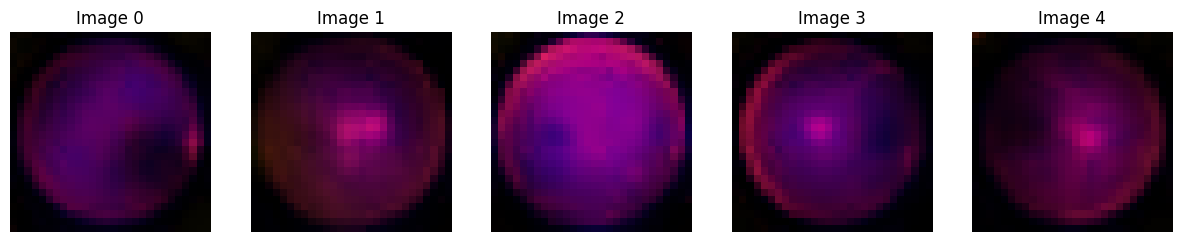

In [6]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 5 columns
# figsize=(width, height) controls how big the overall image is
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Select the image
    img_data = images[i]
    
    # Optional: Normalize if your data is float 0-255
    # img_data = images[i] / 255.0 
    
    # Plot on the specific axis (subplot)
    axes[i].imshow(img_data)
    axes[i].axis('off')  # Hide the axis numbers for a cleaner look
    axes[i].set_title(f"Image {i}")

plt.show()

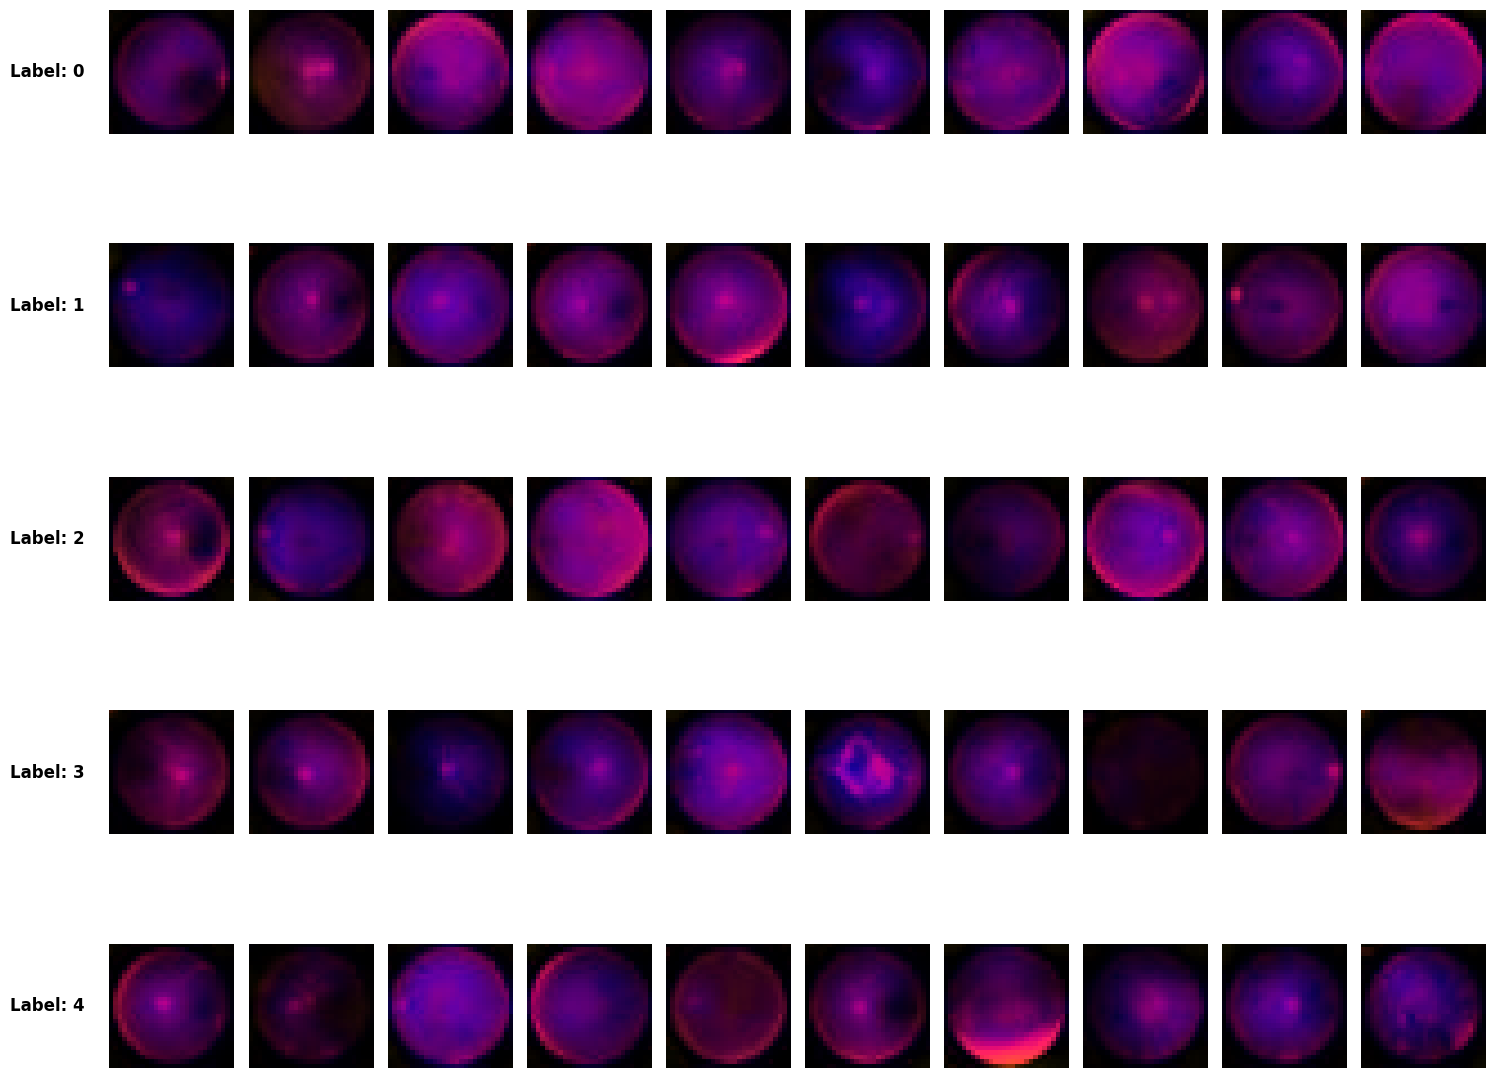

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# 2. Create a big figure: Rows = Number of Classes, Cols = 10 samples
fig, axes = plt.subplots(num_classes, 10, figsize=(15, 2.5 * num_classes))

# 3. Loop through each class and plot
for i, current_label in enumerate(unique_labels):
    # Find indices of all images with this label
    # We use [0] because np.where returns a tuple
    idxs = np.where(labels == current_label)[0]
    
    # Take the first 10 (or fewer if less than 10 exist)
    sample_idxs = idxs[:10]
    
    for j in range(10):
        ax = axes[i, j] if num_classes > 1 else axes[j]
        
        if j < len(sample_idxs):
            # Get the image
            img_idx = sample_idxs[j]
            img = images[img_idx]
            
            # Normalize if necessary (fixes white image issue)
            if img.dtype.kind == 'f' and img.max() > 1:
                img = img / 255.0
                
            ax.imshow(img)
        
        # Clean up axes
        ax.axis('off')
        
        # Add label text only on the first column of the row
        if j == 0:
            ax.text(-0.2, 0.5, f"Label: {current_label}", 
                    transform=ax.transAxes, 
                    fontsize=12, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=uint8)

In [6]:
def one_hot_encode(Y_sparse, num_classes): #we have 5 classes: 0,1,2,3,4
    """
    Converts a sparse label vector (Y_sparse) into a one-hot encoded matrix.

    :param Y_sparse: 1D array of integer labels (e.g., [0, 1, 2, 0])
    :param num_classes: Total number of unique classes (K)
    :return: 2D NumPy array in shape (K, M) for the WX convention
    """
    # 1. Create the identity matrix (K, K)
    # The identity matrix (np.eye(K)) acts as a lookup table.
    # np.eye(3) -> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # 2. Use sparse labels as indices
    # This selects the appropriate row from the identity matrix for each label.
    one_hot_matrix = np.eye(num_classes)[Y_sparse] # Shape: (M, K)

    # 3. Transpose for the WX convention
    # Convert (Samples, Classes) to (Classes, Samples) -> (K, M)
    return one_hot_matrix.T

In [10]:
# This reduces the last dimension from 3 to 1

images_normalized = images.astype('float32') / 255.0
labels_encoded = one_hot_encode(labels.flatten(), num_classes=5)
#X = images_normalized.T  # Shape: (Features, Samples)
Y = labels_encoded       # Shape: (Classes, Samples)
Y

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 1080))

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np

# Set a seed for reproducibility
tf.random.set_seed(42)

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. First Split: Separate Test Set (15%) ---
# We stratify by 'y_full' to ensure the test set has the right class proportions
X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, 
    test_size=0.15, 
    random_state=42, 
    stratify=labels # CRUCIAL: Ensures class balance in the test set
)

# --- 2. Second Split: Separate Train (70%) and Validation (15%) ---
# 0.15 / 0.85 ≈ 0.176. We need 15% of the original data, 
# which is 17.6% of the remaining 85% (X_temp).
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=(0.15 / 0.85), 
    random_state=42, 
    stratify=y_temp # CRUCIAL: Ensures class balance in the validation set
)

# You would then proceed with your normalization and one-hot encoding on 
# X_train, X_val, X_test, y_train, y_val, and y_test.

In [ ]:
X_train = X_train.astype("float32")/255.0
X_val = X_test.astype("float32")/255.0
X_test = X_test.astype("float32")/255.0
y_train = one_hot_encode(y_train.flatten(), num_classes=5)
y_val = one_hot_encode(y_val.flatten(), num_classes=5)
y_test = one_hot_encode(y_test.flatten(), num_classes=5)



In [12]:
# --- Define Model Parameters ---
IMAGE_SIZE = 28
CHANNELS = 3 # Assuming your purple images are color (RGB/3 channels)
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 50

In [13]:
def build_small_cnn(input_shape, num_classes):
    model = Sequential([
        # --- Block 1: 32 Filters ---
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)), # Output size: 14x14

        # --- Block 2: 64 Filters ---
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)), # Output size: 7x7

        # --- Block 3: Feature Extraction ---
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Dropout(0.25), # Dropout to help prevent overfitting
        
        # --- Classification Head ---
        Flatten(), # Prepare for Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5), # Heavier dropout before the final prediction
        Dense(num_classes, activation='softmax') # Output layer (4 classes)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = build_small_cnn((IMAGE_SIZE, IMAGE_SIZE, CHANNELS), NUM_CLASSES)
model.summary()

c:\Users\samyb\ift6758-venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,837 (3.42 MB)

 Trainable params: 896,837 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Data Augmentation Setup ---
train_datagen = ImageDataGenerator(
    rotation_range=15,             # Rotate up to 15 degrees
    width_shift_range=0.1,         # Shift 10% horizontally
    height_shift_range=0.1,        # Shift 10% vertically
    zoom_range=[0.9, 1.1],         # Zoom 10% in or out
    horizontal_flip=True,          # Essential augmentation
    # --- RANDOM BRIGHTNESS SHIFT (10% darker to 10% brighter) ---
    brightness_range=[0.9, 1.1] 
)

# Fit the generator to the training data
train_generator = train_datagen.flow(X_train, y_train_encoded, batch_size=BATCH_SIZE)

In [ ]:
# --- Training the Model ---
# Use EarlyStopping to prevent overfitting and save the best model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_retinal_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE, # Calculate steps for one pass over the data
    epochs=EPOCHS,
    validation_data=(X_val, y_val_encoded),
    callbacks=callbacks
)

# --- Evaluate the Model on the unseen Test Set ---
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

## Train Models

Train and compare multiple machine learning models.

In [273]:
class DeepNN: #we will try 28x28 layers, with relu for each activation except the last layer which will be softmax
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size, random_seed=42):
        """

        :param input_size: Number of features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of neurons in the output layer.
        Initialize weights and biases for a 1-hidden layer neural network
        :
        """
        np.random.seed(random_seed)
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((hidden_size_2, 1))
        self.b3 = np.zeros((output_size, 1))

        std_dev = np.sqrt(1 / input_size)
        self.W1 = np.random.randn(hidden_size, input_size) * std_dev

        std_dev_2 = np.sqrt(1 / hidden_size)
        self.W2 = np.random.randn(hidden_size_2, hidden_size) * std_dev_2

        std_dev_3 = np.sqrt(1 / hidden_size_2)
        self.W3 = np.random.randn(output_size, hidden_size_2) * std_dev_3

    def _relu(self, Z):
        return np.maximum(0, Z)  # ReLU activation for the Hidden Layer
    def _softmax(self, Z):
        """Softmax activation for the Output Layer."""
        # Ensure numerical stability by subtracting max(Z)
        exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    def _relu_derivative(self, A):
        return (A > 0).astype(int)
    def forward_propagate(self, X):
        #Input X must be transposed: (D, M) -> (Features, Samples)
        ### 1st matrix multiplication
        ### Z1 = W1*X + b1 -> then apply activation function
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self._relu(self.Z1)
        ### 2nd matrix multiplication
        ### Z2 = W2*LastOutput+ b2 -> then apply activation function
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self._relu(self.Z2)

        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self._softmax(self.Z3)

        return self.A3
    def back_propagate(self, X, Y, learning_rate):
        """Performs the backward pass and updates weights/biases."""
        m = X.shape[1]  # number of samples

        #1. Calculate output layer error

        dZ3 = self.A3 - Y
        dW3 = (1 / m) * np.dot(dZ3, self.A2.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self._relu_derivative(self.A2)

        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)



        #3. Calculate hidden layer error
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self._relu_derivative(self.A1)

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 5. Update Weights and Biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
    def _calculate_loss(self, Y_true, Y_hat):
        """Calculates the cross-entropy loss."""
        m = Y_true.shape[1]
        loss = -np.sum(Y_true * np.log(Y_hat + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=1000, learning_rate=0.01, log_interval=10):
        """Trains the neural network using the provided training data."""
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            if epoch > 0 and epoch % 500 == 0:
                learning_rate *= 0.5
                print(f"Epoch {epoch}: LR decayed to {learning_rate:.5f}")
            # Forward propagation
            Y_hat_train = self.forward_propagate(X_train)
            # Backward propagation
            self.back_propagate(X_train, Y_train, learning_rate)

            if epoch % log_interval == 0 or epoch == 1:
                train_loss = self._calculate_loss(Y_train, Y_hat_train)
                train_loss_history.append(train_loss)

                Y_hat_valid = self.forward_propagate(X_valid)
                valid_loss = self._calculate_loss(Y_valid, Y_hat_valid)
                valid_loss_history.append(valid_loss)
                #print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                print(f"Epoch {epoch:<4}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
        return train_loss_history, valid_loss_history
    def predict(self, X):
        """Generates binary predictions (0 or 1)."""
        probs = self.forward_propagate(X)
        return np.argmax(probs, axis=0) # argmax along the output unit dimension


Epoch 0   , Train Loss: 1.5910, Val Loss: 1.5789
Epoch 1   , Train Loss: 1.5795, Val Loss: 1.5696
Epoch 20  , Train Loss: 1.4107, Val Loss: 1.4171
Epoch 40  , Train Loss: 1.3546, Val Loss: 1.3771
Epoch 60  , Train Loss: 1.3387, Val Loss: 1.3664
Epoch 80  , Train Loss: 1.3308, Val Loss: 1.3600
Epoch 100 , Train Loss: 1.3251, Val Loss: 1.3540
Epoch 120 , Train Loss: 1.3201, Val Loss: 1.3479
Epoch 140 , Train Loss: 1.3157, Val Loss: 1.3421
Epoch 160 , Train Loss: 1.3114, Val Loss: 1.3365
Epoch 180 , Train Loss: 1.3074, Val Loss: 1.3311
Epoch 200 , Train Loss: 1.3035, Val Loss: 1.3259
Epoch 220 , Train Loss: 1.2997, Val Loss: 1.3209
Epoch 240 , Train Loss: 1.2961, Val Loss: 1.3161
Epoch 260 , Train Loss: 1.2926, Val Loss: 1.3115
Epoch 280 , Train Loss: 1.2892, Val Loss: 1.3070
Epoch 300 , Train Loss: 1.2859, Val Loss: 1.3028
Epoch 320 , Train Loss: 1.2827, Val Loss: 1.2987
Epoch 340 , Train Loss: 1.2796, Val Loss: 1.2949
Epoch 360 , Train Loss: 1.2766, Val Loss: 1.2914
Epoch 380 , Train Lo

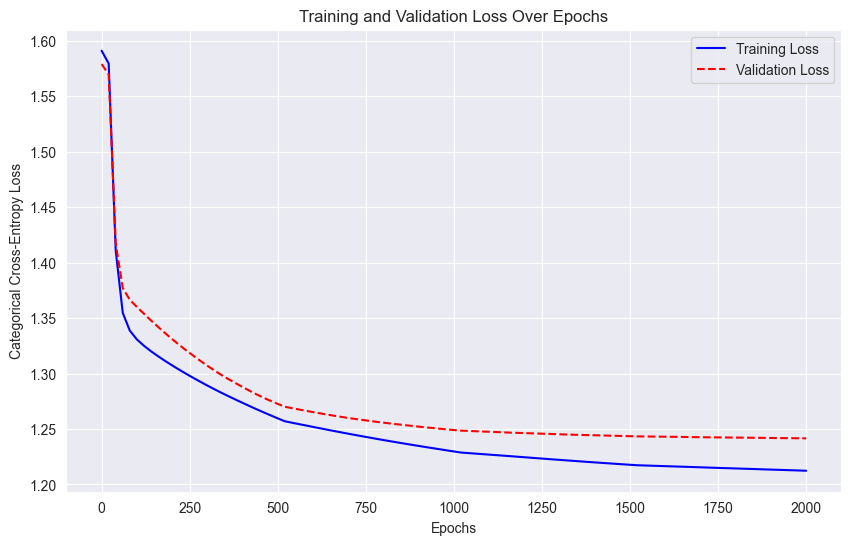

In [280]:
import matplotlib.pyplot as plt
# import numpy as np # Assumed imported

# 1. SETUP AND TRAINING CALL (Assuming X, Y, and train_val_split are defined)

# You must set these variables for the call:
EPOCHS = 2000  # Example value ###1500 gives accuracy of 0.5 with hidden dim = 10, learning rate = 0.05
LEARNING_RATE = 0.05 # Example value
HIDDEN_DIM = 150 # Example value
HIDDEN_DIM_2 = 50 # Example value
LOG_INTERVAL = 20 # How often to record loss

# Initialize NN (using dimensions from the split data)
INPUT_DIM = X_train.shape[0]
OUTPUT_DIM = Y_train.shape[0]

nn = DeepNN(INPUT_DIM, HIDDEN_DIM, HIDDEN_DIM_2,  OUTPUT_DIM)

# Train the model and get the loss histories
train_loss, val_loss = nn.train(
    X_train, Y_train,
    X_val, Y_val,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    log_interval=LOG_INTERVAL
)

# 1. Use the length of the actual data returned by the training
actual_length = len(train_loss)

# 2. Generate indices based on that length
# This ensures x and y are always the same size, regardless of EPOCHS settings
epochs_to_plot = np.arange(actual_length) * LOG_INTERVAL

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, val_loss, label='Validation Loss', color='red', linestyle='--')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('loss_curve.png') # Use this if running in a non-interactive environment

In [281]:
# Predict on Training Set
train_preds = nn.predict(X_train)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse = np.argmax(Y_train, axis=0)
train_acc = np.mean(train_preds == Y_train_sparse)

# Predict on Validation Set
val_preds = nn.predict(X_val)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse = np.argmax(Y_val, axis=0)
val_acc = np.mean(val_preds == Y_val_sparse)

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Training Accuracy:   49.42%
Validation Accuracy: 50.93%


In [283]:
import pickle

# Load the pickle file
with open('data/test_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images_test = data['images']

array([[[[27, 16,  0],
         [17, 11,  0],
         [11,  9,  0],
         ...,
         [ 0,  0,  0],
         [ 2,  0,  0],
         [ 7,  0,  1]],

        [[17, 11,  0],
         [16, 10,  0],
         [14,  9,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 2,  0,  1]],

        [[ 9,  6,  0],
         [13,  7,  0],
         [12,  5,  0],
         ...,
         [ 0,  0,  2],
         [ 0,  0,  2],
         [ 0,  0,  4]],

        ...,

        [[13,  7,  0],
         [ 9,  5,  0],
         [ 7,  3,  0],
         ...,
         [ 0,  0,  2],
         [ 1,  0,  0],
         [ 3,  2,  0]],

        [[14,  9,  0],
         [ 9,  6,  0],
         [ 8,  4,  0],
         ...,
         [ 1,  0,  0],
         [ 3,  1,  0],
         [ 5,  3,  0]],

        [[13,  8,  0],
         [ 9,  6,  0],
         [ 7,  5,  0],
         ...,
         [ 1,  0,  0],
         [ 5,  3,  0],
         [ 5,  3,  0]]],


       [[[ 4,  3,  0],
         [ 2,  1,  0],
         [ 3, 

In [284]:
# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_test = np.dot(images_test[..., :3], rgb_weights)



images_test = images_test.reshape(images_test.shape[0], -1)
images_test = images_test / 255.0
X_test = images_test.T  # Shape: (Features, Samples)


In [302]:
test_preds = nn.predict(X_test)
test_preds


array([0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 2, 0, 0, 0, 2, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3,
       0, 2, 0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 3,
       0, 2, 3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 2, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 2, 0, 0, 3, 3,
       3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3,
       0, 0, 0, 3, 0, 2, 3, 3, 0, 3, 0, 3, 0, 3, 0,

In [306]:
import pandas as pd
import numpy as np

# 1. Create the DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_preds)+1), # Adjust to range(1, ...) if you need 1-based indexing
    'Label': test_preds
})


# 3. Export
submission.to_csv('data/submission.csv', index=False)

print("\n--- Raw File Preview (First 5 lines) ---")
with open('data/submission.csv', 'r') as f:
    for _ in range(5):
        print(f.readline().strip())


--- Raw File Preview (First 5 lines) ---
ID,Label
1,0
2,2
3,0
4,0


## Evaluate Models

Analyze your best model's performance (see README.md for evaluation guidelines).

In [22]:
####################################################################
###############   TO complete   ####################################
####################################################################

## Generate Predictions for Kaggle Submission

Create a CSV file with columns: `id` and `quality` (see README.md for format details).

In [ ]:

####################################################################
###############   TO complete   ####################################
####################################################################

---
Good luck with the competition! 🍺
